In [424]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import pandas_datareader as data_reader
import datetime
import ta
from sklearn import preprocessing, linear_model, metrics, neighbors, feature_selection, ensemble, multioutput, svm, model_selection
from statsmodels import regression

In [425]:
appl = data_reader.get_data_yahoo('AAPL', start=datetime.datetime(2001, 1, 1), end=datetime.datetime(2019, 8, 9))
spy = data_reader.get_data_yahoo('SPY', start=datetime.datetime(2001, 1, 1), end=datetime.datetime(2019, 8, 9))
appl.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2001-01-02,1.089286,1.040179,1.062500,1.062500,113078000.0,0.924482
2001-01-03,1.191964,1.031250,1.035714,1.169643,204268400.0,1.017707
2001-01-04,1.321429,1.200893,1.295759,1.218750,184849000.0,1.060436
2001-01-05,1.241071,1.147321,1.209821,1.169643,103089000.0,1.017707
2001-01-08,1.213170,1.138393,1.209821,1.183036,93424800.0,1.029361


In [426]:
appl.describe()

,High,Low,Open,Close,Volume,Adj Close
count,4680.000000,4680.000000,4680.000000,4680.000000,4.680000e+03,4680.000000
mean,59.227883,58.098642,58.676359,58.677083,1.165798e+08,54.727269
std,60.710405,59.693577,60.194961,60.212747,9.681993e+07,58.504425
min,0.942143,0.908571,0.927857,0.937143,9.835000e+06,0.815409
25%,6.736786,6.598214,6.663571,6.643214,4.818730e+07,5.780266
50%,35.111429,34.330713,34.683571,34.713572,8.871345e+07,30.204314
75%,99.892502,98.042501,98.682501,98.782499,1.540704e+08,91.709465
max,233.470001,229.779999,230.779999,232.070007,8.432424e+08,227.839798


In [427]:
appl.dropna(inplace=True)
spy.dropna(inplace=True)

In [428]:
return_appl = appl['Adj Close'].pct_change()[1:]
return_spy = spy['Adj Close'].pct_change()[1:]

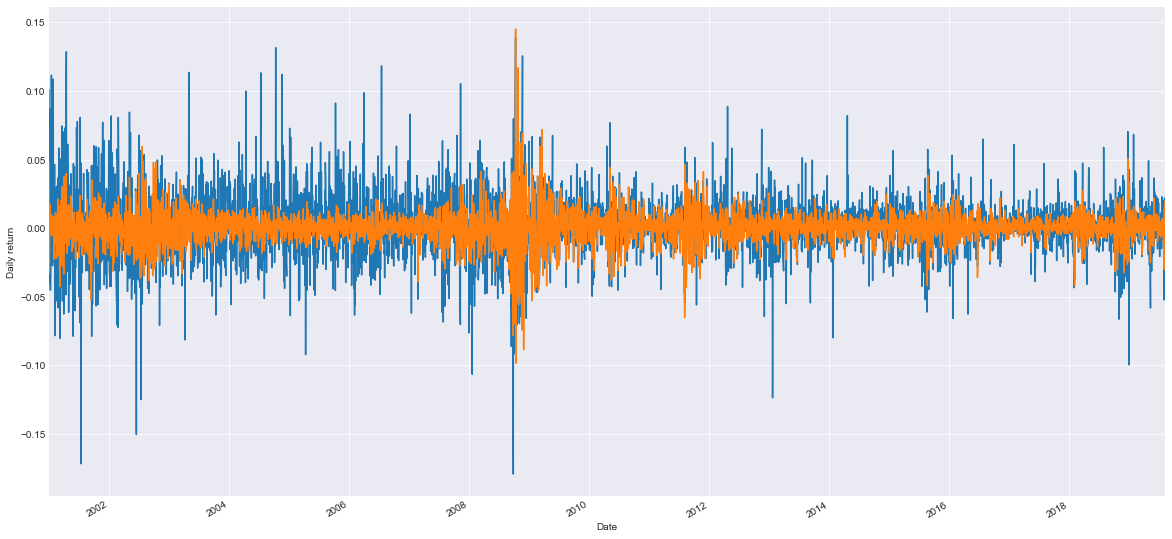

In [429]:
plt.figure(figsize=(20,10))
return_appl.plot()
return_spy.plot()
plt.ylabel("Daily return") 
plt.show()

In [396]:
def calculate_alpha_and_beta(x, y, periods):
    x_values = x['Adj Close'].pct_change()[1:].values
    y_values = y['Adj Close'].pct_change()[1:].values
    
    betas = [None for index in range(periods + 1)]
    alphas = [None for index in range(periods + 1)]
    
    for index in range(len(x_values) - periods):
        X = x_values[index: (index + periods)]
        Y = y_values[index: (index + periods)]

        X = sm.add_constant(X)
        model = regression.linear_model.OLS(Y, X).fit()
        
        alphas.append(model.params[0])
        betas.append(model.params[1])

    y['alpha'] = np.array(alphas) 
    y['beta'] = np.array(betas) 
        
    return y.copy()

In [430]:
appl = calculate_alpha_and_beta(spy, appl, 64)

In [398]:
def fourier_transforms(data, numbers):
    close_fft = np.fft.fft(np.asarray(data['Adj Close'].tolist()))
    fft_df = pd.DataFrame({'fft':close_fft})
    fft_list = np.asarray(fft_df['fft'].tolist())

    for num_ in [3, 6, 9, 100]:
        fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
        data['Fourier_{}'.format(num_)] = np.fft.ifft(fft_list_m10)
    
    return data

In [431]:
def get_technical_indicators(dataset, spy):
    # Assuming 0 for now
    daily_rf_rate = 0
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['Adj Close'].rolling(window=7).mean()
    dataset['ma21'] = dataset['Adj Close'].rolling(window=21).mean()
    dataset['SMA100'] = dataset['Adj Close'].rolling(window=100).mean()

    # Create MACD
    dataset['26ema'] = dataset['Adj Close'].ewm(span=26, adjust=False).mean()
    dataset['12ema'] = dataset['Adj Close'].ewm(span=12, adjust=False).mean()
    dataset['MACD'] = (dataset['12ema'] - dataset['26ema'])

    # Create Bollinger Bands
    dataset['20sd'] = dataset['Adj Close'].rolling(20).std()
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)

    # Create Exponential moving average
    dataset['ema'] = dataset['Adj Close'].ewm(span=100).mean()
    dataset['ROC'] = ((dataset['Adj Close'] - dataset['Adj Close'].shift(100)) / dataset['Adj Close'].shift(100)) * 100
    dataset['SPY_SMA_100'] = spy['Adj Close'].rolling(window=100).mean()
    
    # Compute Volatility on spy and index 
    dataset['SPY_Vol'] = np.log(spy['Adj Close'] / spy['Adj Close'].shift(1)).rolling(window=60).std() * np.sqrt(252)
    dataset['Log_Returns'] = np.log(dataset['Adj Close'] / dataset['Adj Close'].shift(1))
    dataset['Vol'] = dataset['Log_Returns'].rolling(window=60).std() * np.sqrt(252)
    dataset['Sharpe_Ratio'] = (dataset['Log_Returns'].rolling(window=60).mean() - daily_rf_rate) / dataset['Vol']
    
    return dataset

In [432]:
appl = get_technical_indicators(appl, spy)
appl.dropna(inplace=True)
appl.describe()

,High,Low,Open,Close,Volume,Adj Close,ma7,ma21,SMA100,26ema,...,20sd,upper_band,lower_band,ema,ROC,SPY_SMA_100,SPY_Vol,Log_Returns,Vol,Sharpe_Ratio
count,4580.000000,4580.000000,4580.000000,4580.000000,4.580000e+03,4580.000000,4580.000000,4580.000000,4580.000000,4580.000000,...,4580.000000,4580.000000,4580.000000,4580.000000,4580.000000,4580.000000,4580.000000,4580.000000,4580.000000,4580.000000
mean,60.487236,59.335435,59.924770,59.925416,1.164906e+08,55.893626,55.764288,55.454240,53.776219,55.347813,...,1.591247,58.636733,52.271747,53.807112,14.830453,132.366011,0.161155,0.001077,0.332192,0.004629
std,60.761875,59.745607,60.246235,60.264470,9.744218e+07,58.598945,58.484502,58.197130,56.667325,58.062855,...,1.876879,61.277489,55.200205,56.621128,27.280823,61.390064,0.095472,0.022293,0.129037,0.008704
min,0.942143,0.908571,0.927857,0.937143,9.835000e+06,0.815409,0.827306,0.860453,0.896770,0.863244,...,0.015558,0.924447,0.671332,0.902513,-54.964303,63.017444,0.049786,-0.197470,0.103573,-0.018383
25%,8.627857,8.337857,8.528214,8.508929,4.727588e+07,7.403627,7.291623,7.253475,6.842763,7.369599,...,0.269071,7.888846,6.567145,7.112726,-0.911313,86.056159,0.106341,-0.009538,0.232196,-0.001384
50%,37.124287,36.366428,36.719286,36.752857,8.821820e+07,31.978696,31.718377,31.699938,30.050067,31.570441,...,0.986109,33.394677,29.531916,30.167419,13.890772,107.866123,0.130904,0.000942,0.310198,0.004718
75%,100.725718,98.852497,99.842501,99.962143,1.544265e+08,92.593307,92.472814,92.083176,94.224057,92.388400,...,2.198864,96.162370,87.645340,94.767155,28.689641,182.095063,0.190176,0.012190,0.402581,0.010534
max,233.470001,229.779999,230.779999,232.070007,8.432424e+08,227.839798,223.224060,219.401228,205.928441,218.637046,...,15.069447,228.119122,211.761917,205.801093,141.700234,287.762976,0.755843,0.130194,0.931176,0.033084


In [433]:
print(appl.columns)

Index(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'alpha', 'beta',
       'ma7', 'ma21', 'SMA100', '26ema', '12ema', 'MACD', '20sd', 'upper_band',
       'lower_band', 'ema', 'ROC', 'SPY_SMA_100', 'SPY_Vol', 'Log_Returns',
       'Vol', 'Sharpe_Ratio'],
      dtype='object')


In [434]:
appl['close'] = appl['Adj Close']
appl = appl.drop(['Adj Close', 'Close', 'Volume'], axis=1)

In [435]:
appl['alpha'].describe()

count     4580.000000
unique    4580.000000
top          0.000771
freq         1.000000
Name: alpha, dtype: float64

In [436]:
appl['beta'].describe()

count     4580.000000
unique    4580.000000
top          1.040408
freq         1.000000
Name: beta, dtype: float64

In [437]:
columns = list(appl.columns)
print(columns)

['High', 'Low', 'Open', 'alpha', 'beta', 'ma7', 'ma21', 'SMA100', '26ema', '12ema', 'MACD', '20sd', 'upper_band', 'lower_band', 'ema', 'ROC', 'SPY_SMA_100', 'SPY_Vol', 'Log_Returns', 'Vol', 'Sharpe_Ratio', 'close']


In [438]:
appl.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4580 entries, 2001-05-25 to 2019-08-09
Data columns (total 22 columns):
High            4580 non-null float64
Low             4580 non-null float64
Open            4580 non-null float64
alpha           4580 non-null object
beta            4580 non-null object
ma7             4580 non-null float64
ma21            4580 non-null float64
SMA100          4580 non-null float64
26ema           4580 non-null float64
12ema           4580 non-null float64
MACD            4580 non-null float64
20sd            4580 non-null float64
upper_band      4580 non-null float64
lower_band      4580 non-null float64
ema             4580 non-null float64
ROC             4580 non-null float64
SPY_SMA_100     4580 non-null float64
SPY_Vol         4580 non-null float64
Log_Returns     4580 non-null float64
Vol             4580 non-null float64
Sharpe_Ratio    4580 non-null float64
close           4580 non-null float64
dtypes: float64(20), object(2)
memory usa

In [439]:
appl['alpha'] = appl['alpha'].astype(np.float64)

In [440]:
appl['beta'] = appl['beta'].astype(np.float64)

In [441]:
appl.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4580 entries, 2001-05-25 to 2019-08-09
Data columns (total 22 columns):
High            4580 non-null float64
Low             4580 non-null float64
Open            4580 non-null float64
alpha           4580 non-null float64
beta            4580 non-null float64
ma7             4580 non-null float64
ma21            4580 non-null float64
SMA100          4580 non-null float64
26ema           4580 non-null float64
12ema           4580 non-null float64
MACD            4580 non-null float64
20sd            4580 non-null float64
upper_band      4580 non-null float64
lower_band      4580 non-null float64
ema             4580 non-null float64
ROC             4580 non-null float64
SPY_SMA_100     4580 non-null float64
SPY_Vol         4580 non-null float64
Log_Returns     4580 non-null float64
Vol             4580 non-null float64
Sharpe_Ratio    4580 non-null float64
close           4580 non-null float64
dtypes: float64(22)
memory usage: 823.0

In [442]:
appl.dropna(inplace=True)

In [443]:
def split_data(data):
        total_length = len(data)
        train_index = round(0.8 * total_length)
        
        train = data[:int(train_index), :]
        test = data[int(train_index):, :]
        
        return train, test

In [444]:
print(np.any(np.isnan(appl)))
print(np.all(np.isfinite(appl)))

False
True


In [445]:
appl.head()

,High,Low,Open,alpha,beta,ma7,ma21,SMA100,26ema,12ema,...,upper_band,lower_band,ema,ROC,SPY_SMA_100,SPY_Vol,Log_Returns,Vol,Sharpe_Ratio,close
Date,,,,,,,,,,,,,,,,,,,,,
2001-05-25,1.663571,1.607143,1.657143,0.003119,1.630788,1.450139,1.503972,1.313010,1.461760,1.458801,...,1.646082,1.361863,1.379821,53.008419,88.024202,0.269006,-0.019148,0.679779,0.004752,1.414536
2001-05-29,1.607143,1.486429,1.594286,0.002948,1.635992,1.431671,1.489974,1.316177,1.452323,1.439656,...,1.643548,1.336400,1.378786,31.114528,87.971303,0.269008,-0.058348,0.689571,0.002638,1.334362
2001-05-30,1.482857,1.378571,1.482857,0.002236,1.658992,1.398377,1.473075,1.317866,1.435805,1.407298,...,1.653296,1.292854,1.375394,15.926709,87.916088,0.270044,-0.081985,0.700874,-0.000705,1.229328
2001-05-31,1.445714,1.392143,1.414286,0.001228,1.708568,1.366325,1.455377,1.320088,1.421293,1.381544,...,1.640169,1.270585,1.372328,21.832071,87.895855,0.269358,0.008558,0.692000,-0.001802,1.239894
2001-06-01,1.506429,1.427143,1.437857,0.001618,1.678210,1.343152,1.438508,1.322777,1.412183,1.368739,...,1.627405,1.249611,1.370658,26.128281,87.874101,0.269260,0.046042,0.698364,-0.000408,1.298315


In [446]:
appl.tail()

,High,Low,Open,alpha,beta,ma7,ma21,SMA100,26ema,12ema,...,upper_band,lower_band,ema,ROC,SPY_SMA_100,SPY_Vol,Log_Returns,Vol,Sharpe_Ratio,close
Date,,,,,,,,,,,,,,,,,,,,,
2019-08-05,198.649994,192.580002,197.990005,-0.000492,1.587492,205.035913,203.737148,194.969472,202.290059,203.679869,...,212.032522,195.441775,194.045942,6.810050,287.359909,0.135156,-0.053768,0.274509,-0.002041,192.031647
2019-08-06,198.070007,194.039993,196.309998,-0.000501,1.620263,203.512009,203.594312,195.108275,201.799454,202.447102,...,212.519136,194.669488,194.078039,7.635471,287.451764,0.137801,0.018753,0.275874,-0.000055,195.666885
2019-08-07,199.559998,193.820007,195.410004,-0.000426,1.603469,202.002295,203.490258,195.243692,201.495278,201.715715,...,212.790266,194.190250,194.149625,7.353597,287.531611,0.127127,0.010302,0.246789,0.004678,197.693085
2019-08-08,203.529999,199.389999,200.199997,-0.000277,1.605457,201.243182,203.499717,195.403913,201.536619,201.767663,...,212.708826,194.290607,194.306134,8.612590,287.657595,0.131816,0.021816,0.248639,0.005053,202.053375
2019-08-09,202.759995,199.289993,201.300003,-0.000446,1.570014,199.641756,203.499890,195.562227,201.451564,201.555466,...,212.794997,194.204782,194.426575,8.578032,287.762976,0.132252,-0.008275,0.248386,0.003703,200.388382


In [447]:
train, test = split_data(appl.values)

In [448]:
print("Train: ", np.any(np.isnan(appl)))
print("Train: ", np.all(np.isfinite(appl)))

print("Test: ", np.any(np.isnan(test)))
print("Test: ", np.all(np.isfinite(test)))

Train:  False
Train:  True
Test:  False
Test:  True


In [449]:
def normalize_data(train, test):
        normalizer = preprocessing.Normalizer()
        train = normalizer.fit_transform(train)
        test = normalizer.transform(test)        
        return train, test

In [450]:
train, test = normalize_data(train, test)

In [451]:
print("Train data shape: ", train.shape)
print("Test data shape: ", test.shape)

Train data shape:  (3664, 22)
Test data shape:  (916, 22)


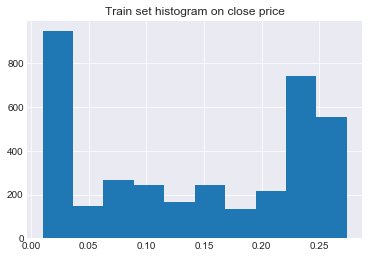

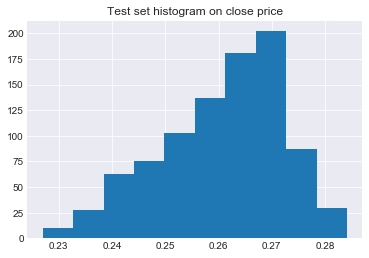

In [452]:
plt.hist(train[:,-1])
plt.title("Train set histogram on close price") 
plt.show()

plt.hist(test[:,-1])
plt.title("Test set histogram on close price") 
plt.show()

In [453]:
def formate_data(data, x_len, y_len):
        x_s = []
        y_s = []
        
        for index in range(len(data) - (x_len + y_len)):
            # We delete the close price from the xs
            x_s.append(data[index: (index + x_len), :-1])
            # We just want the close price as target variable
            y_s.append(data[(index + x_len):(index + x_len + y_len), -1])
        
        x_s = np.array(x_s)
        y_s = np.array(y_s)
        
        return x_s, y_s

In [422]:
def formate_data(xs, ys, x_len, y_len):
        x_s = []
        y_s = []
        
        for index in range(len(xs) - (x_len + y_len)):
            # We delete the close price from the xs
            x_s.append(xs[index: (index + x_len), :])
            # We just want the close price as target variable
            y_s.append(ys[(index + x_len):(index + x_len + y_len)])
        
        x_s = np.array(x_s)
        y_s = np.array(y_s)
        
        return x_s, y_s

In [454]:
x_train, y_train = formate_data(train, 24, 7)
x_test, y_test = formate_data(test, 24, 7)

print("X train shape:", x_train.shape)
print("Y train shape:", y_train.shape)

print("X test shape:", x_test.shape)
print("Y test shape:", y_test.shape)

X train shape: (3633, 24, 21)
Y train shape: (3633, 7)
X test shape: (885, 24, 21)
Y test shape: (885, 7)


In [ ]:
#clf = linear_model.MultiTaskLassoCV(cv=5)

# Set a minimum threshold of 0.25
#sfm = feature_selection.SelectFromModel(clf, threshold=0.05)
#sfm.fit(np.reshape(x_train, (3633, 24 * 21)), y_train)
#x_train = sfm.transform(x_train)
#x_test = sfm.transform(x_test)

#print("After Selection train (X) data shape: ", x_train.shape)
#print("After Selection test (X) data shape: ", x_test.shape)
print("Skip")

In [455]:
X = np.reshape(x_train, (3633, 24 * 21))
y = y_train
reg = linear_model.LinearRegression().fit(X, y)
print(reg.score(X, y))

0.9979327102357586


/anaconda3/envs/sp500/lib/python3.6/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


In [456]:
Xt = np.reshape(x_test, (885, 24 * 21))
yt = y_test
pred = reg.predict(Xt)
print("yt shape: ", yt.shape)
print("pred shape: ", pred.shape)

yt shape:  (885, 7)
pred shape:  (885, 7)


In [457]:
mse = metrics.mean_squared_error(yt, pred)
print("Mean Squared Error: ", mse)

Mean Squared Error:  3.1618823291253525e-05


In [ ]:
def plot_results_against_true_data(tested_data, true_data, title="Results comparison"):
        plt.figure(figsize = (15,6))
        # style
        plt.style.use('seaborn-darkgrid')

        plt.plot(
            range(len(tested_data)), 
            tested_data, 
            marker='', 
            color="blue", 
            linewidth=0.5, 
            alpha=1, 
            label="Predicted Data"
        )

        plt.plot(
            range(len(true_data)), 
            true_data, 
            marker='', 
            color="black", 
            linewidth=0.5, 
            alpha=0.8, 
            label="Real Data"
        )

        plt.legend(loc=2, ncol=2)
        plt.title(title, loc='left', fontsize=12, fontweight=0, color='orange')
        plt.xlabel("Days")
        plt.ylabel("Price")
        plt.show()

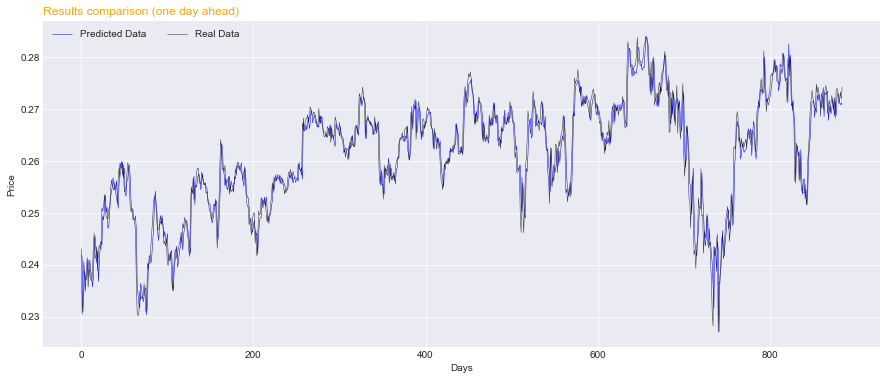

In [458]:
plot_results_against_true_data(pred[:,0], yt[:,0], title="Results comparison (one day ahead)")

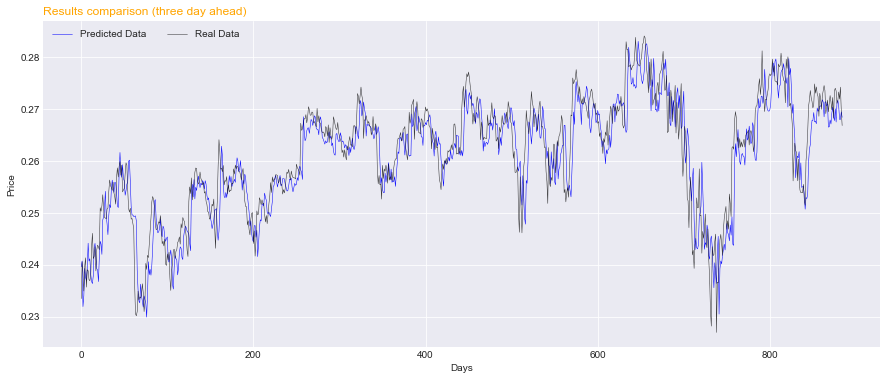

In [459]:
plot_results_against_true_data(pred[:,2], yt[:,2], title="Results comparison (three day ahead)")

In [460]:
print(pred[:,0].max())

0.28386781543421546


In [461]:
Xt = np.reshape(x_test, (885, 24 * 21))
yt = y_test

In [462]:
def tune_estimators(x, y, x_test, y_test):
    n_estimators = [1, 2, 4, 8, 16, 32, 64, 100]
    train_results = []
    test_results = []
    
    for estimator in n_estimators:
        reg = ensemble.GradientBoostingRegressor(n_estimators=estimator)
        model = multioutput.MultiOutputRegressor(reg, n_jobs=-1).fit(x, y)
        train_pred = model.predict(x)
        mse_tr = metrics.mean_squared_error(y, train_pred)
        train_results.append(mse_tr)
        y_pred = model.predict(x_test)
        mse_test = metrics.mean_squared_error(y_test, y_pred)
        test_results.append(mse_test)
    
    from matplotlib.legend_handler import HandlerLine2D
    line1, = plt.plot(n_estimators, train_results, 'b', label="Train MSE")
    line2, = plt.plot(n_estimators, test_results, 'r', label="Test MSE")
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('MSE score')
    plt.xlabel('n_estimators')
    plt.show()

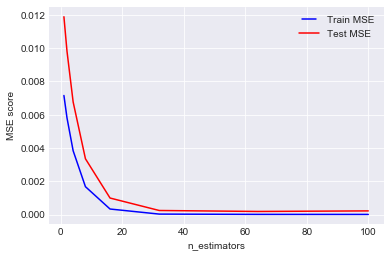

In [463]:
tune_estimators(X, y, Xt, yt)

In [464]:
def tune_lr(x, y, x_test, y_test):
    l_rates = [0.25, 0.1, 0.05, 0.01]
    train_results = []
    test_results = []
    
    for eta in l_rates:
        reg = ensemble.GradientBoostingRegressor(n_estimators=40, learning_rate=eta)
        model = multioutput.MultiOutputRegressor(reg, n_jobs=-1).fit(x, y)
        train_pred = model.predict(x)
        mse_tr = metrics.mean_squared_error(y, train_pred)
        train_results.append(mse_tr)
        y_pred = model.predict(x_test)
        mse_test = metrics.mean_squared_error(y_test, y_pred)
        test_results.append(mse_test)
    
    from matplotlib.legend_handler import HandlerLine2D
    line1, = plt.plot(l_rates, train_results, 'b', label="Train MSE")
    line2, = plt.plot(l_rates, test_results, 'r', label="Test MSE")
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('MSE score')
    plt.xlabel('l_rate')
    plt.show()

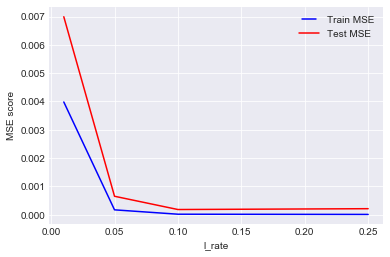

In [465]:
tune_lr(X, y, Xt, yt)

In [466]:
def max_depth(x, y, x_test, y_test):
    max_depths = np.linspace(1, 15, 15, endpoint=True)
    train_results = []
    test_results = []
    
    for max_depth in max_depths:
        print("Max depth: ", max_depth)
        reg = ensemble.GradientBoostingRegressor(n_estimators=40, learning_rate=0.15, max_depth=max_depth)
        model = multioutput.MultiOutputRegressor(reg, n_jobs=-1).fit(x, y)
        train_pred = model.predict(x)
        mse_tr = metrics.mean_squared_error(y, train_pred)
        train_results.append(mse_tr)
        y_pred = model.predict(x_test)
        mse_test = metrics.mean_squared_error(y_test, y_pred)
        test_results.append(mse_test)
    
    from matplotlib.legend_handler import HandlerLine2D
    line1, = plt.plot(max_depths, train_results, 'b', label="Train MSE")
    line2, = plt.plot(max_depths, test_results, 'r', label="Test MSE")
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('MSE score')
    plt.xlabel('max_depth')
    plt.show()

Max depth:  1.0
Max depth:  2.0
Max depth:  3.0
Max depth:  4.0
Max depth:  5.0
Max depth:  6.0
Max depth:  7.0
Max depth:  8.0
Max depth:  9.0
Max depth:  10.0
Max depth:  11.0
Max depth:  12.0
Max depth:  13.0
Max depth:  14.0
Max depth:  15.0


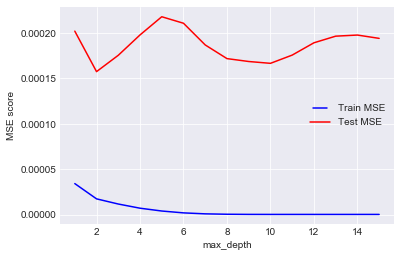

In [467]:
max_depth(X, y, Xt, yt)

In [468]:
def min_samples_split(x, y, x_test, y_test):
    min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
    train_results = []
    test_results = []
    
    for min_samples_split in min_samples_splits:
        print("Min Samples Split: ", min_samples_split)
        reg = ensemble.GradientBoostingRegressor(
            n_estimators=40, 
            learning_rate=0.15, 
            max_depth=2.0, 
            min_samples_split=min_samples_split
        )
        model = multioutput.MultiOutputRegressor(reg, n_jobs=-1).fit(x, y)
        train_pred = model.predict(x)
        mse_tr = metrics.mean_squared_error(y, train_pred)
        train_results.append(mse_tr)
        y_pred = model.predict(x_test)
        mse_test = metrics.mean_squared_error(y_test, y_pred)
        test_results.append(mse_test)
    
    from matplotlib.legend_handler import HandlerLine2D
    line1, = plt.plot(min_samples_splits, train_results, 'b', label="Train MSE")
    line2, = plt.plot(min_samples_splits, test_results, 'r', label="Test MSE")
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('MSE score')
    plt.xlabel('min_samples_splits')
    plt.show()

Min Samples Split:  0.1
Min Samples Split:  0.2
Min Samples Split:  0.30000000000000004
Min Samples Split:  0.4
Min Samples Split:  0.5
Min Samples Split:  0.6
Min Samples Split:  0.7000000000000001
Min Samples Split:  0.8
Min Samples Split:  0.9
Min Samples Split:  1.0


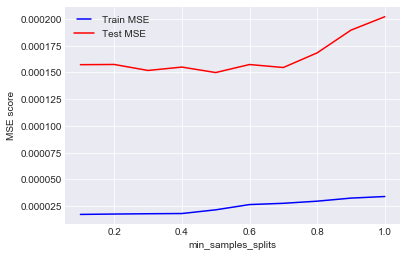

In [469]:
min_samples_split(X, y, Xt, yt)

In [470]:
def min_samples_leaf(x, y, x_test, y_test):
    min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)

    train_results = []
    test_results = []
    
    for min_samples_leaf in min_samples_leafs:
        print("Min Samples Leaf: ", min_samples_leaf)
        reg = ensemble.GradientBoostingRegressor(
            n_estimators=40, 
            learning_rate=0.15, 
            max_depth=2.0, 
            min_samples_split=0.4,
            min_samples_leaf=min_samples_leaf
        )
        model = multioutput.MultiOutputRegressor(reg, n_jobs=-1).fit(x, y)
        train_pred = model.predict(x)
        mse_tr = metrics.mean_squared_error(y, train_pred)
        train_results.append(mse_tr)
        y_pred = model.predict(x_test)
        mse_test = metrics.mean_squared_error(y_test, y_pred)
        test_results.append(mse_test)
    
    from matplotlib.legend_handler import HandlerLine2D
    line1, = plt.plot(min_samples_leafs, train_results, 'b', label="Train MSE")
    line2, = plt.plot(min_samples_leafs, test_results, 'r', label="Test MSE")
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('MSE score')
    plt.xlabel('min_samples_leaf')
    plt.show()

Min Samples Leaf:  0.1
Min Samples Leaf:  0.2
Min Samples Leaf:  0.30000000000000004
Min Samples Leaf:  0.4
Min Samples Leaf:  0.5


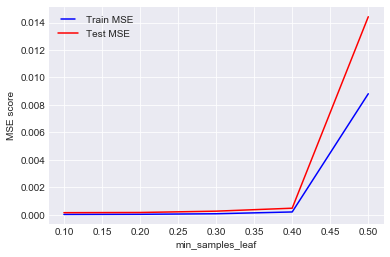

In [471]:
min_samples_leaf(X, y, Xt, yt)

In [472]:
def max_features(x, y, x_test, y_test):
    max_features = list(range(1, 25))

    train_results = []
    test_results = []
    
    for max_feature in max_features:
        print("Max Feature: ", max_feature)
        reg = ensemble.GradientBoostingRegressor(
            n_estimators=40, 
            learning_rate=0.15, 
            max_depth=2.0, 
            min_samples_split=0.4,
            min_samples_leaf=0.4,
            max_features=max_feature
        )
        model = multioutput.MultiOutputRegressor(reg, n_jobs=-1).fit(x, y)
        train_pred = model.predict(x)
        mse_tr = metrics.mean_squared_error(y, train_pred)
        train_results.append(mse_tr)
        y_pred = model.predict(x_test)
        mse_test = metrics.mean_squared_error(y_test, y_pred)
        test_results.append(mse_test)
    
    from matplotlib.legend_handler import HandlerLine2D
    line1, = plt.plot(max_features, train_results, 'b', label="Train MSE")
    line2, = plt.plot(max_features, test_results, 'r', label="Test MSE")
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('MSE score')
    plt.xlabel('max_features')
    plt.show()

Max Feature:  1
Max Feature:  2
Max Feature:  3
Max Feature:  4
Max Feature:  5
Max Feature:  6
Max Feature:  7
Max Feature:  8
Max Feature:  9
Max Feature:  10
Max Feature:  11
Max Feature:  12
Max Feature:  13
Max Feature:  14
Max Feature:  15
Max Feature:  16
Max Feature:  17
Max Feature:  18
Max Feature:  19
Max Feature:  20
Max Feature:  21
Max Feature:  22
Max Feature:  23
Max Feature:  24


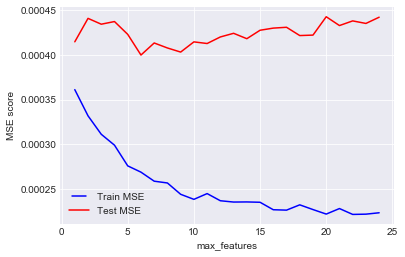

In [473]:
max_features(X, y, Xt, yt)

In [474]:
reg = ensemble.GradientBoostingRegressor(
    n_estimators=40, 
    learning_rate=0.15, 
    max_depth=2.0, 
    min_samples_split=0.40,
    min_samples_leaf=0.40
)
reg = multioutput.MultiOutputRegressor(reg, n_jobs=-1).fit(X, y)
print(reg.score(X, y))

0.9775157324029967


In [475]:
Xt = np.reshape(x_test, (885, 24 * 21))
yt = y_test
pred = reg.predict(Xt)
print("yt shape: ", yt.shape)
print("pred shape: ", pred.shape)

yt shape:  (885, 7)
pred shape:  (885, 7)


In [476]:
mse = metrics.mean_squared_error(yt, pred)
print("Score: ", reg.score(Xt, pred))
print("Mean Squared Error: ", mse)

Score:  1.0
Mean Squared Error:  0.00047188664819649537


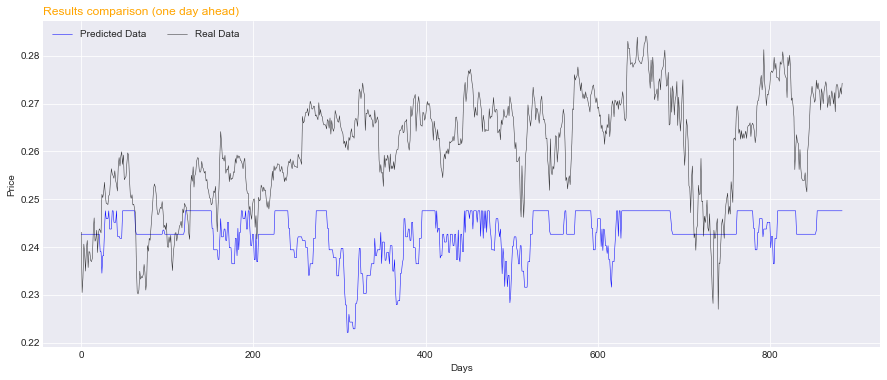

In [477]:
plot_results_against_true_data(pred[:,0], yt[:,0], title="Results comparison (one day ahead)")

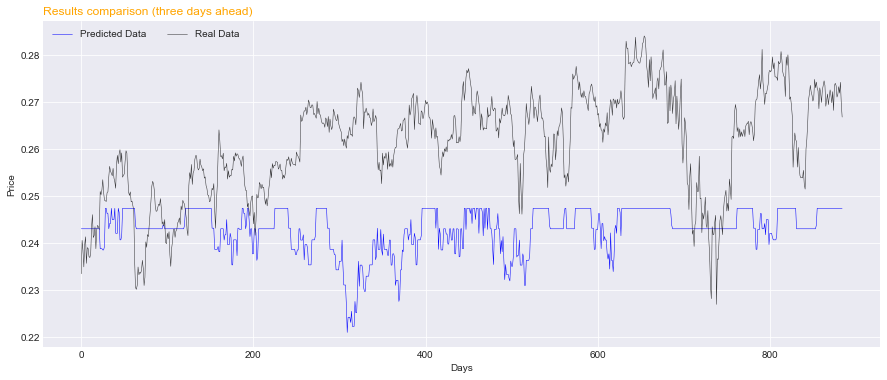

In [478]:
plot_results_against_true_data(pred[:,2], yt[:,2], title="Results comparison (three days ahead)")

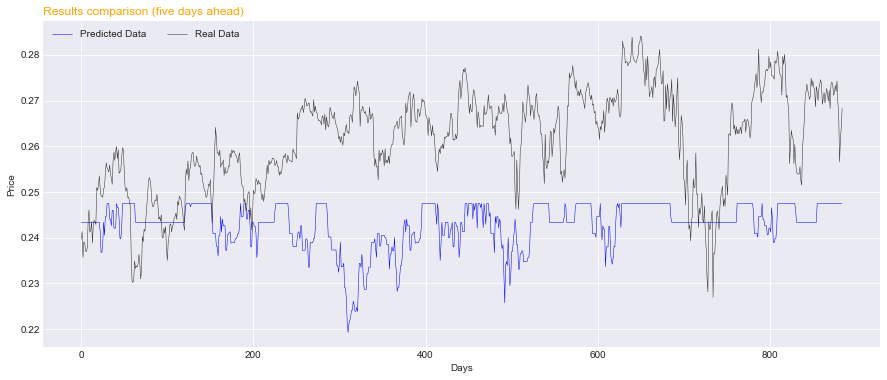

In [479]:
plot_results_against_true_data(pred[:,6], yt[:,6], title="Results comparison (five days ahead)")

In [480]:
X = np.reshape(x_train, (3633, 24 * 21))
y = y_train
reg = neighbors.KNeighborsRegressor(n_neighbors=35).fit(X, y)
print(reg.score(X, y))

0.9966311983904161


/anaconda3/envs/sp500/lib/python3.6/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


In [482]:
Xt = np.reshape(x_test, (885, 24 * 21))
yt = y_test
pred = reg.predict(Xt)
print("yt shape: ", yt.shape)
print("pred shape: ", pred.shape)

yt shape:  (885, 7)
pred shape:  (885, 7)


In [483]:
mse = metrics.mean_squared_error(yt, pred)
print("Mean Squared Error: ", mse)

Mean Squared Error:  0.0001626993898863688


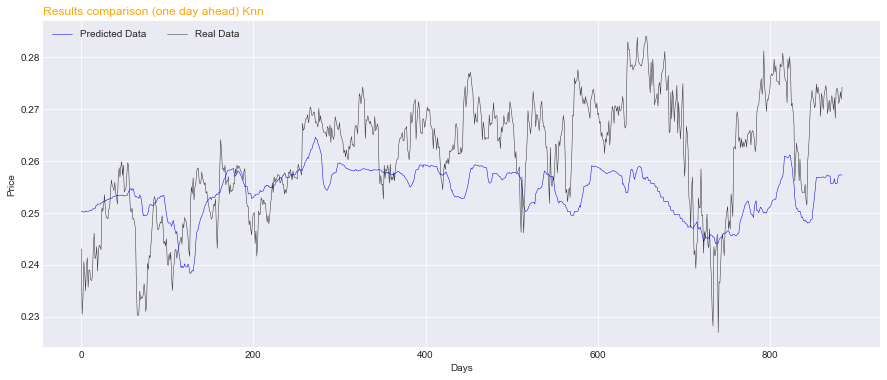

In [484]:
plot_results_against_true_data(pred[:,0], yt[:,0], title="Results comparison (one day ahead) Knn")

In [485]:
from tensorflow.keras.layers import Activation, Dense, GRU
from tensorflow.keras.models import Sequential

In [486]:
def build(amount_of_features, seq_len):
            
        model = Sequential()

        model.add(GRU(
            units=256,
            activation="tanh",
            return_sequences=True,
            dropout=0.2,
            input_shape=(seq_len, amount_of_features)
            )
        )

        model.add(GRU(
            units=256,
            activation="tanh",
            return_sequences=False,
            dropout=0.2
            )
        )

        model.add(Dense(64, activation="relu"))
        model.add(Dense(7, activation="linear"))

        model.summary()

        model.compile(
            optimizer="Nadam",
            loss="mse"
        )

        return model

In [487]:
reg = build(21, 24)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 24, 256)           213504    
_________________________________________________________________
gru_1 (GRU)                  (None, 256)               393984    
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 455       
Total params: 624,391
Trainable params: 624,391
Non-trainable params: 0
_________________________________________________________________


In [488]:
def train_model(
        model, 
        x_train, 
        y_train,
        batch_size,
        epochs
    ):
    
        history = model.fit(
            x=x_train, 
            y=y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_split=0.1,
            shuffle=False
        )

        return history, model

In [489]:
hist, model = train_model(reg, x_train, y_train, 256, 10)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 3269 samples, validate on 364 samples
Epoch 1/10
3269/3269 [==============================] - 28s 9ms/sample - loss: 0.0046 - val_loss: 4.7156e-04
Epoch 2/10
3269/3269 [==============================] - 18s 6ms/sample - loss: 0.0030 - val_loss: 9.9058e-04
Epoch 3/10
3269/3269 [==============================] - 19s 6ms/sample - loss: 0.0021 - val_loss: 1.6739e-04
Epoch 4/10
3269/3269 [==============================] - 20s 6ms/sample - loss: 0.0013 - val_loss: 0.0013
Epoch 5/10
3269/3269 [==============================] - 18s 6ms/sample - loss: 0.0011 - val_loss: 8.1285e-04
Epoch 6/10
3269/3269 [==============================] - 19s 6ms/sample - loss: 0.0011 - val_loss: 6.2123e-04
Epoch 7/10
3269/3269 [==============================] - 18s 6ms/sample - loss: 8.7862e-04 - val_loss: 6.6622e-04
Epoch 8/10
3269/3269 [==============================] - 19s 6ms/sample - loss: 7.8686e-04 - val_

In [490]:
scores = model.evaluate(x_test, y_test, verbose=0)
print(scores)

0.0004030883127736654


In [491]:
results = model.predict(x_test)
print(results.shape)

(885, 7)


In [492]:
mse = metrics.mean_squared_error(y_test, results)
print("Mean Squared Error: ", mse)

Mean Squared Error:  0.00040308829817592646


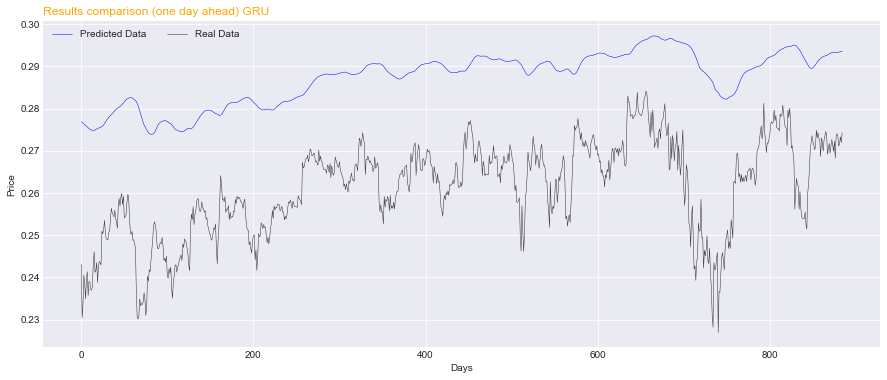

In [493]:
plot_results_against_true_data(results[:,0], y_test[:,0], title="Results comparison (one day ahead) GRU")